# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Imports
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import itertools
import cv2
import math
import time
import os

import textwrap
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set this to True if the data is already augmented and saved
AUGMENTED = True

# Specify the data folders
training_file = './data/train.p'
training_file_augmented = './data/train_augmented.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

# Extract the training dataset, use augmented data if AUGMENTED is set to True
if not AUGMENTED:
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    X_train, y_train = train['features'], train['labels']
else:
    with open(training_file_augmented, mode='rb') as f:
        train_augmented = pickle.load(f)
    X_train, y_train = train_augmented['features'], train_augmented['labels']

# Extract validation dataset
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
X_valid, y_valid = valid['features'], valid['labels']

# Extract testing dataset
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test, y_test = test['features'], test['labels']

# Show dataset information
print('X_train: type {}, shape {}'.format(X_train.dtype, X_train.shape))
print('y_train: type {}, shape {}'.format(y_train.dtype, y_train.shape))
print('---')
print('X_valid: type {}, shape {}'.format(X_valid.dtype, X_valid.shape))
print('y_valid: type {}, shape {}'.format(y_valid.dtype, y_valid.shape))
print('---')
print('X_test : type {}, shape {}'.format(X_test.dtype, X_test.shape))
print('y_test : type {}, shape {}'.format(y_test.dtype, y_test.shape))

X_train: type uint8, shape (172000, 32, 32, 3)
y_train: type int64, shape (172000,)
---
X_valid: type uint8, shape (4410, 32, 32, 3)
y_valid: type uint8, shape (4410,)
---
X_test : type uint8, shape (12630, 32, 32, 3)
y_test : type uint8, shape (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_valid = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset?
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 172000
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

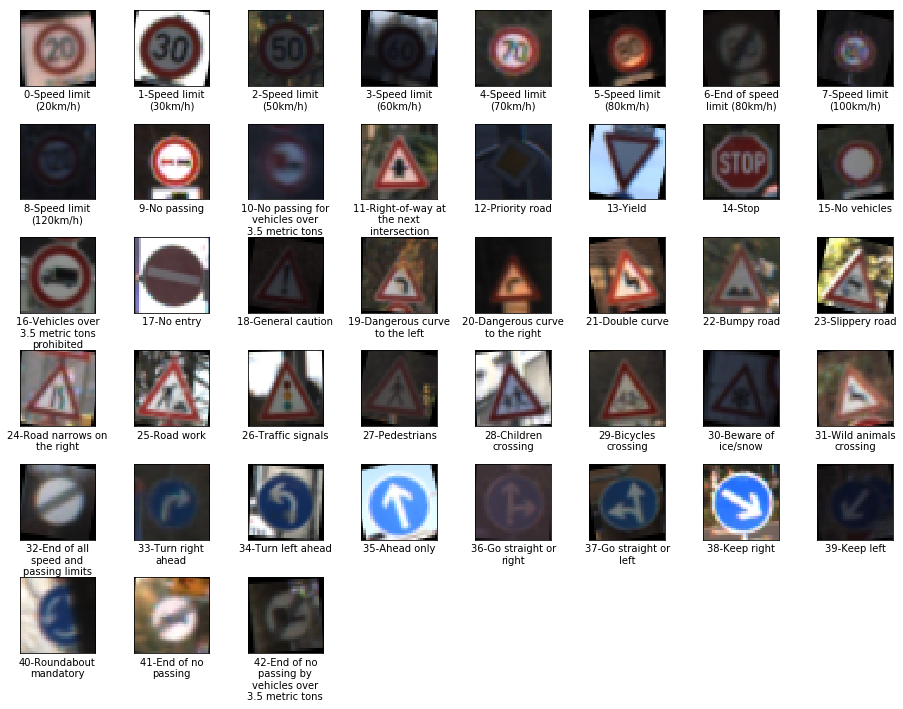

In [4]:
# Get the id -> name mapping for classes
df = pd.read_csv('signnames.csv')
sign_names = df['SignName'].tolist()

def plot_images(images, labels):
    """
    Helper function to plot sample images in a grid.
    """
    assert images.shape[0] == labels.shape[0]
    
    n_images = images.shape[0]
    n_channels = images.shape[-1]
    
    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(hspace=0.5)
    for i in range(n_images):
        if i == n_images: break;
            
        ax = plt.subplot(8, 8, i + 1)
        if n_channels == 3:
            ax.imshow(images[i])
        elif n_channels == 1:
            ax.imshow(images[i].squeeze(), cmap='gray')
            
        ax.set_xlabel('{}-{}'.format(labels[i], '\n'.join(textwrap.wrap(sign_names[labels[i]], 15))))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Show one image per class
train_samples_indices = np.zeros(n_classes).astype(int)
for i in range(n_classes):
    class_i_images_indices = np.where(y_train == i)[0]
    train_samples_indices[i] = np.random.choice(class_i_images_indices)
plot_images(X_train[train_samples_indices], y_train[train_samples_indices])

In [5]:
# Augment data
def perturb(image, angle, offset=(0, 0), scale=1.0):
    """
    Perturb the image with OpenCV function cv2.warpAffine()
    """
    (h, w) = image.shape[:2]
    center = (w // 2 + offset[0], h // 2 + offset[1])
    M = cv2.getRotationMatrix2D(center, angle, scale)
    image = cv2.warpAffine(image, M, (w, h))

    return image

def perturb_randomly(image):
    """
    Randomly perturb the image. 
    - Rotate (-15, 15) degree.
    - Shift (-2, 2) pixels.
    - Scale (0.9, 1.1) times.
    """
    angle = np.random.randint(-15, 16)
    offset = (np.random.randint(-2, 3), np.random.randint(-2, 3))
    scale = np.random.uniform(0.9, 1.1)
    image = perturb(image, angle, offset, scale)
    return image

if not AUGMENTED:
    # Plot the count of each sign
    print('Training set statistics:')
    unique, unique_counts = np.unique(y_train, return_counts=True)
    fig, ax = plt.subplots()
    ax.bar(unique, unique_counts)
    ax.set_xlabel('Class index')
    ax.set_ylabel('Counts')
    plt.show()
    
    # Augment data
    X_train_augment = []
    y_train_augment = []
    for i in range(n_classes):
        n_original_images = unique_counts[i]
        if n_original_images < 4000:
            X = X_train[y_train == i]
            for _ in range(4000 - n_original_images):
                image = X[np.random.randint(0, X.shape[0])]
                X_train_augment.append(perturb_randomly(image))
                y_train_augment.append(i)
    X_train_augment = np.stack(X_train_augment, axis=0)
    y_train_augment = np.stack(y_train_augment, axis=0)

    # Combine augmented data with the original data
    train_augmented = {}
    train_augmented['features'] = np.vstack((X_train, X_train_augment))
    train_augmented['labels'] = np.append(y_train, y_train_augment)
    print(train_augmented['features'].shape)
    print(train_augmented['labels'].shape)

    # Write the augmented dataset to file
    with open(training_file_augmented, mode='wb') as f:
        pickle.dump(train_augmented, f)

    # Now all calsses should have 4000 training images
    unique, unique_counts = np.unique(train_augmented['labels'], return_counts=True)
    fig, ax = plt.subplots()
    ax.bar(unique, unique_counts)
    ax.set_xlabel('Class index')
    ax.set_ylabel('Counts')
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Preprocessing done.
Processed images:


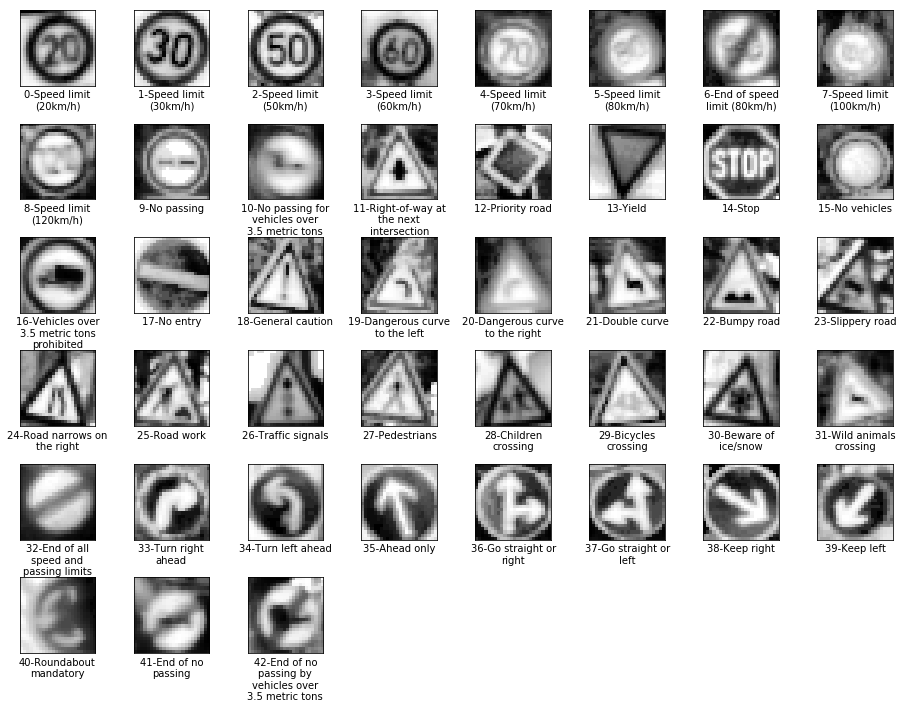

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
def pre_process_single_image(image):
    """
    Pre-process a single image.
    """
    # Convert to gray scale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Crop image to 24x24 from 32x32
    image = image[4:28, 4:28]
    # Histogram equalization
    image = cv2.equalizeHist(image)
    # Convert to floating point numbers
    image_float = image[:, :, np.newaxis] / 255.0
    # Per image normalization
    n_pixels = np.prod(image_float.shape)
    image_mean = np.mean(image_float)
    image_std = np.std(image_float)
    adjusted_std = max(image_std, 1.0 / math.sqrt(n_pixels))
    
    return (image_float - image_mean) / adjusted_std

def pre_process_images(images):
    """
    Pre-process a image dataset.
    """
    processed_images = np.empty((images.shape[0], 24, 24, 1), dtype=float)
    for i in range(images.shape[0]):
        processed_images[i] = pre_process_single_image(images[i])
        
    return processed_images

# Pre-processing
X_train_normalized = pre_process_images(X_train)
X_valid_normalized = pre_process_images(X_valid)
X_test_normalized = pre_process_images(X_test)
print('Preprocessing done.')

# Show process sample images.
print('Processed images:')
plot_images(X_train_normalized[train_samples_indices], y_train[train_samples_indices])

Define placeholders.

In [7]:
x = tf.placeholder(tf.float32, shape=[None, 24, 24, 1])  # The processed image has shape (24, 24, 1)
y = tf.placeholder(tf.int32, shape=[None])
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

### Model Architecture

In [8]:
## Define your architecture here.

def conv_relu(x, kernel_shape, bias_shape, padding='VALID'):
    """
    Create a convolution layer with relu activation.
    """
    weights = tf.get_variable("weights", kernel_shape,
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    biases = tf.get_variable("biases", bias_shape,
                             initializer=tf.constant_initializer(0.0))
    conv = tf.nn.conv2d(x, weights,
                        strides=[1, 1, 1, 1], padding=padding)
    
    return tf.nn.relu(conv + biases)

def fc_relu(x, weight_shape, bias_shape):
    """
    Create a fully connected layer with relu activation.
    """
    weights = tf.get_variable('weights', weight_shape, 
                              initializer=tf.truncated_normal_initializer(stddev=0.1))
    biases = tf.get_variable('biases', bias_shape, 
                             initializer=tf.constant_initializer(0.0))
    
    return tf.nn.relu(tf.matmul(x, weights) + biases)

def max_pool_2d(x):
    """
    Create max polling layer.
    """
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def LeNet(x):  
    """
    Build the LeNet network.
    """
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    with tf.variable_scope("conv1"):
        conv1 = conv_relu(x, [5, 5, 1, 6], [6], padding='VALID')
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pool1 = max_pool_2d(conv1)
    # Layer 2: Convolutional. Output = 10x10x16.
    with tf.variable_scope("conv2"):
        conv2 = conv_relu(pool1, [5, 5, 6, 16], [16], padding='VALID')
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pool2 = max_pool_2d(conv2)
    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = tf.contrib.layers.flatten(pool2)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    with tf.variable_scope("fc1"):
        fc1 = fc_relu(fc0, [400, 120], [120])
    # Dropout.
    dropout1 = tf.nn.dropout(fc1, keep_prob)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    with tf.variable_scope("fc2"):
        fc2 = fc_relu(dropout1, [120, 84], [84])
    # Dropout.
    dropout2 = tf.nn.dropout(fc2, keep_prob)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    with tf.variable_scope("fc3"):
        logits = fc_relu(dropout2, [84, 43], [43])
        
    return logits

def build_network(x):  
    """
    Build the LeNet network.
    """
    # Layer 1: Convolutional. Input = 24x24x1. Output = 24x24x64.
    with tf.variable_scope("conv1"):
        conv1 = conv_relu(x, [5, 5, 1, 64], [64], padding='SAME')
    # Pooling. Output = 12x12x64.
    pool1 = max_pool_2d(conv1)
    # Layer 2: Convolutional. Output = 12x12x64.
    with tf.variable_scope("conv2"):
        conv2 = conv_relu(pool1, [5, 5, 64, 64], [64], padding='SAME')
    # Pooling. Output = 6x6x64.
    pool2 = max_pool_2d(conv2)
    # Flatten. Input = 6x6x64. Output = 4096.
    fc0 = tf.contrib.layers.flatten(pool2)
    # Layer 3: Fully Connected. Input = 4096. Output = 120.
    with tf.variable_scope("fc1"):
        fc1 = fc_relu(fc0, [6*6*64, 120], [120])
    # Dropout.
    dropout1 = tf.nn.dropout(fc1, keep_prob)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    with tf.variable_scope("fc2"):
        fc2 = fc_relu(dropout1, [120, 84], [84])
    # Dropout.
    dropout2 = tf.nn.dropout(fc2, keep_prob)
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    with tf.variable_scope("fc3"):
        logits = fc_relu(dropout2, [84, 43], [43])
        
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# Hyperparameters.
LEARNING_RATE = 0.001

# Operations.
logits = build_network(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss)
prediction_op = tf.argmax(tf.nn.softmax(logits), axis=1)
top5_op = tf.nn.top_k(tf.nn.softmax(logits), k=5)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Display parameter information.

In [10]:
total_n_params = 0
for var in tf.trainable_variables():
    n_params = 1
    for dim in var.get_shape():
        n_params *= dim.value
    total_n_params += n_params
    print('name: {:>15} | shape: {:>15} | # of params: {:>10}'.format(var.name, str(var.get_shape()), n_params))

print('---')
print('Total # of params: {}'.format(total_n_params))

name: conv1/weights:0 | shape:   (5, 5, 1, 64) | # of params:       1600
name:  conv1/biases:0 | shape:           (64,) | # of params:         64
name: conv2/weights:0 | shape:  (5, 5, 64, 64) | # of params:     102400
name:  conv2/biases:0 | shape:           (64,) | # of params:         64
name:   fc1/weights:0 | shape:     (2304, 120) | # of params:     276480
name:    fc1/biases:0 | shape:          (120,) | # of params:        120
name:   fc2/weights:0 | shape:       (120, 84) | # of params:      10080
name:    fc2/biases:0 | shape:           (84,) | # of params:         84
name:   fc3/weights:0 | shape:        (84, 43) | # of params:       3612
name:    fc3/biases:0 | shape:           (43,) | # of params:         43
---
Total # of params: 394547


Evaluate how well the loss and accuracy of the model for a given dataset.

In [11]:
def evaluate(X_data, y_data):
    """
    Evaluate using validation/test dataset.
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (acc * len(batch_x))
        
    return total_accuracy / num_examples

Actually train the model.

In [12]:
# Hyperparameters.
EPOCHS = 20
BATCH_SIZE = 256
BATCHES_PER_EPOCH = n_train // BATCH_SIZE

def random_batch():
    """
    Create a random batch.
    """
    idx = np.random.choice(n_train, size=BATCH_SIZE, replace=False)
    x_batch = X_train_normalized[idx]
    y_batch = y_train[idx]

    return x_batch, y_batch

# Prepare for saving check points.
saver = tf.train.Saver()
save_dir = './checkpoints'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# Training.
train_loss_history = []
valid_accuracy_history = []
with tf.Session() as sess:
    # Intialize variables
    sess.run(tf.global_variables_initializer())

    print("Start training...")
    for i_epoch in range(EPOCHS):
        # We calculate the time taken for each epoch
        start_time = time.time()
        
        train_loss = 0.0
        for _ in range(BATCHES_PER_EPOCH):
            batch_x, batch_y = random_batch()
            _, batch_loss, batch_accuracy = sess.run([train_op, loss, accuracy], 
                                                     feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            train_loss += batch_loss

        end_time = time.time()
        # Training speed
        speed = BATCHES_PER_EPOCH * BATCH_SIZE / (end_time - start_time)

        # Training loss
        train_loss_history.append(train_loss / BATCHES_PER_EPOCH)
        
        # Print validation accuracy
        valid_accuracy_history.append(evaluate(X_valid_normalized, y_valid))
        
        print('Epoch {:03d} --- Training speed: {:.0f} images/sec --- Training loss: {:.3f} ' \
              '--- Validation accuracy: {:.3f}'.format(
            (i_epoch + 1), speed, train_loss_history[-1], valid_accuracy_history[-1]))


    # Save the model
    print("Training finished!")
    saver.save(sess, './checkpoints/lenet')
    print("Model saved")

Start training...
Epoch 001 --- Training speed: 19304 images/sec --- Training loss: 2.154 --- Validation accuracy: 0.840
Epoch 002 --- Training speed: 21356 images/sec --- Training loss: 0.888 --- Validation accuracy: 0.931
Epoch 003 --- Training speed: 22015 images/sec --- Training loss: 0.577 --- Validation accuracy: 0.965
Epoch 004 --- Training speed: 23761 images/sec --- Training loss: 0.417 --- Validation accuracy: 0.977
Epoch 005 --- Training speed: 23158 images/sec --- Training loss: 0.328 --- Validation accuracy: 0.980
Epoch 006 --- Training speed: 23618 images/sec --- Training loss: 0.271 --- Validation accuracy: 0.983
Epoch 007 --- Training speed: 22327 images/sec --- Training loss: 0.228 --- Validation accuracy: 0.985
Epoch 008 --- Training speed: 22393 images/sec --- Training loss: 0.196 --- Validation accuracy: 0.984
Epoch 009 --- Training speed: 22921 images/sec --- Training loss: 0.172 --- Validation accuracy: 0.988
Epoch 010 --- Training speed: 22699 images/sec --- Trai

Plot training and validation summary.

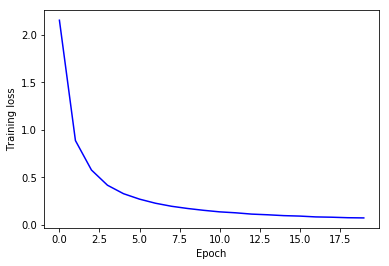

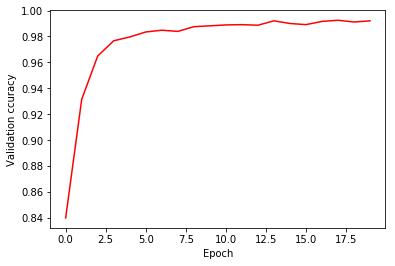

In [13]:
# Plot training accuracy
fig, ax = plt.subplots()
ax.plot(train_loss_history, 'b-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Training loss')
plt.show()

# Plot validation accuracy
fig, ax = plt.subplots()
ax.plot(valid_accuracy_history, 'r-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Validation ccuracy')
plt.show()

Finally, evaluate the performance on the test dataset.

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints'))
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints/lenet
Test Accuracy = 0.973


Calcualte the performance matrics.

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints'))
    y_prediction = sess.run(prediction_op, feed_dict={x: X_test_normalized, 
                                                      y: y_test, 
                                                      keep_prob: 1.0})
true_number = np.zeros(n_classes)
predicted_number = np.zeros(n_classes)
true_positives = np.zeros(n_classes)
false_positives = np.zeros(n_classes)
for i in range(n_classes):
    # Number of images are actually belong to class i
    true_number[i] = np.sum(y_test == i)
    # Number of images classified as class i
    predicted_number[i] = np.sum(y_prediction == i)
    # Within these, the following actually belong to class i
    true_positives[i] = np.sum(y_test[y_prediction == i] == i)
    # The rest are false positives
    false_positives[i] = predicted_number[i] - true_positives[i]

precision = true_positives / predicted_number
recall = true_positives / true_number

print('Precision:')
print(precision)
print('Recall:')
print(recall)

INFO:tensorflow:Restoring parameters from ./checkpoints/lenet
Precision:
[ 0.96363636  0.97796143  0.95274585  0.98383372  0.98012232  0.94267516
  1.          0.96536797  0.97533632  0.98562628  1.          0.98095238
  0.99274311  0.99722607  0.97463768  0.98130841  1.          1.          0.9501385
  1.          0.92941176  0.94565217  0.96747967  0.93670886  0.97802198
  0.97046414  0.83673469  0.69863014  0.93548387  0.92783505  0.93984962
  0.94366197  0.98360656  1.          0.99166667  0.99488491  1.          1.
  0.99853587  0.98876404  0.97701149  1.          0.97826087]
Recall:
[ 0.88333333  0.98611111  0.99466667  0.94666667  0.97121212  0.93968254
  0.88        0.99111111  0.96666667  1.          0.98030303  0.98095238
  0.99130435  0.99861111  0.9962963   1.          0.99333333  1.
  0.87948718  1.          0.87777778  0.96666667  0.99166667  0.98666667
  0.98888889  0.95833333  0.91111111  0.85        0.96666667  1.
  0.83333333  0.99259259  1.          0.9952381   0.991

Compute and plot confusion matrix.

Confusion matrix, without normalization:


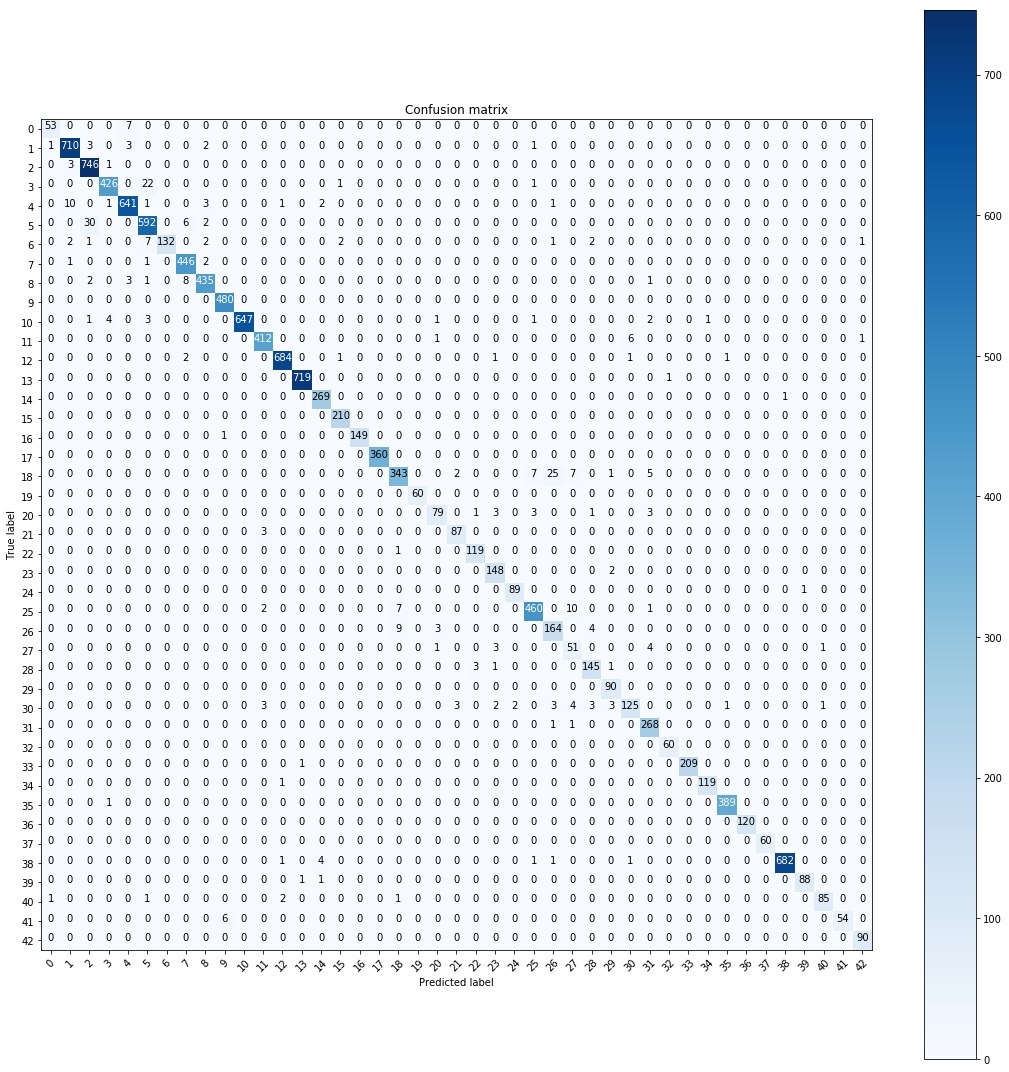

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix:")
    else:
        print('Confusion matrix, without normalization:')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_prediction)
plt.figure(figsize=(15, 15))
plot_confusion_matrix(cm, classes=range(n_classes), normalize=False)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

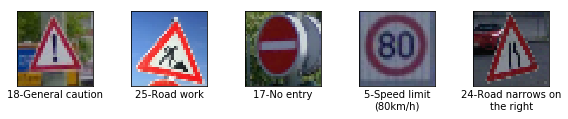

In [17]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# Load the image downloaded from web.
n_test_samples = 5
new_images_folder = './submission/new_images'
X_test_samples = []
for i in range(n_test_samples):
    image = cv2.imread(new_images_folder + '/new_image_' + str(i) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    X_test_samples.append(image)
X_test_samples = np.stack(X_test_samples, axis=0)
y_test_samples = np.array([18, 25, 17, 5, 24])
plot_images(X_test_samples, y_test_samples)

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./checkpoints/lenet
     True labels: [18 25 17  5 24]
Predicted labels: [18 25 17  5 24]


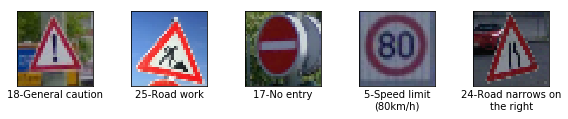

In [18]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
# Preprocess the image
X_test_samples_normalized = pre_process_images(X_test_samples)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints'))
    y_prediction = sess.run(prediction_op, feed_dict={x: X_test_samples_normalized, 
                                                      y: y_test_samples, 
                                                      keep_prob: 1.0})

print('     True labels: {}'.format(y_test_samples))
print('Predicted labels: {}'.format(y_prediction))
plot_images(X_test_samples, y_prediction)

### Analyze Performance

In [19]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints'))
    test_accuracy = evaluate(X_test_samples_normalized, y_test_samples)
    print("Test Accuracy = {:.3f}%".format(test_accuracy * 100))

INFO:tensorflow:Restoring parameters from ./checkpoints/lenet
Test Accuracy = 100.000%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./checkpoints/lenet
TopKV2(values=array([[  1.00000000e+00,   1.12268381e-16,   6.93862413e-22,
          2.98336269e-24,   3.10356616e-25],
       [  1.00000000e+00,   1.02814014e-12,   1.20018999e-15,
          8.41955938e-16,   4.25577146e-16],
       [  1.00000000e+00,   1.71615680e-10,   1.21843987e-14,
          5.91510983e-18,   8.89668111e-19],
       [  6.93741798e-01,   1.55967280e-01,   1.13813892e-01,
          3.36338617e-02,   2.41668685e-03],
       [  9.99987602e-01,   1.24504986e-05,   4.30346210e-12,
          3.63408088e-12,   7.89874459e-13]], dtype=float32), indices=array([[18, 26, 22, 37, 27],
       [25, 22, 31, 17, 23],
       [17, 34, 38, 12, 14],
       [ 5,  2,  7,  3, 10],
       [24, 27, 23, 30, 25]], dtype=int32))


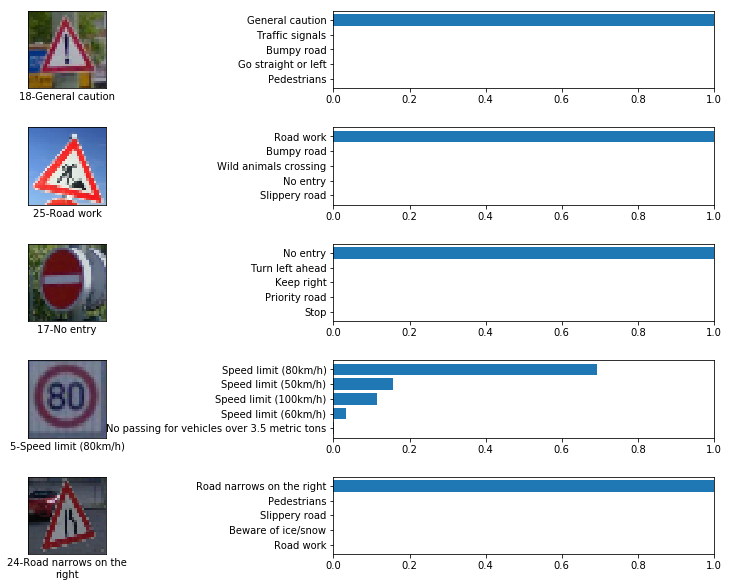

In [21]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints'))
    top5 = sess.run(top5_op, feed_dict={x: X_test_samples_normalized, 
                                        y: y_test_samples, 
                                        keep_prob: 1.0})

print(top5)

fig, ax = plt.subplots(n_test_samples, 2, figsize=(15, 2 * n_test_samples))
fig.subplots_adjust(hspace=0.5)
for i in range(n_test_samples):
    ax[i, 0].imshow(X_test_samples[i]) 
    ax[i, 0].set_xticks([])
    ax[i, 0].set_yticks([])
    ax[i, 0].set_xlabel('{}-{}'.format(y_test_samples[i], 
                                       '\n'.join(textwrap.wrap(sign_names[y_test_samples[i]], 20))))
    ax[i, 1].barh(range(5), top5.values[i, :][::-1])
    ax[i, 1].set_xlim([0, 1.0])
    ax[i, 1].set_yticks(range(5))
    ax[i, 1].set_yticklabels([sign_names[j] for j in top5.indices[i]][::-1])
plt.show()

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from ./checkpoints/lenet


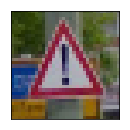

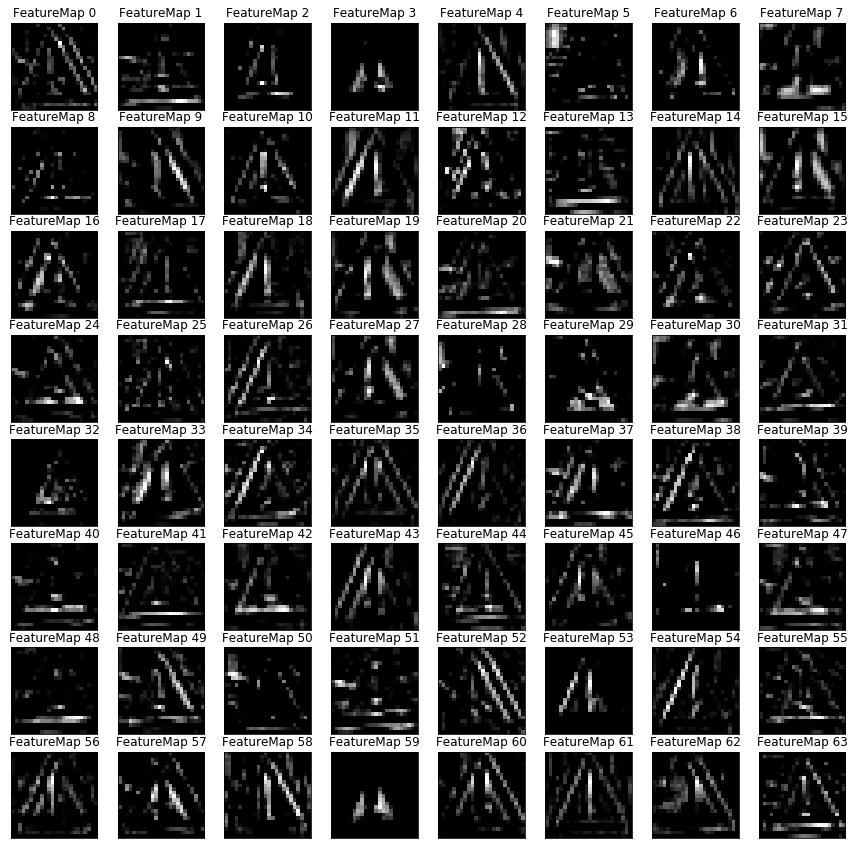

In [22]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x : image_input})
    # print('activation shape: {}, dtype: {}'.format(str(activation.shape), activation.dtype))
    # print('activation max: {}, min: {}'.format(np.max(activation), np.min(activation)))
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(8,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.xticks([])
        plt.yticks([])
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

# print([tensor.name for tensor in tf.get_default_graph().as_graph_def().node])
# print(tf.get_default_graph().get_tensor_by_name('Relu:0'))
# Plot for test sample images
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./checkpoints'))
    
    for i in [0]:
        # Show the original image
        plt.figure(figsize=(2,2))
        plt.imshow(X_test_samples[i])
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        # Show features
        image = X_test_samples_normalized[i]
        outputFeatureMap(image[np.newaxis, :, :, :], 
                         tf.get_default_graph().get_tensor_by_name('conv1/Relu:0'), 
                         activation_min=-1,
                         activation_max=-1,
                         plt_num=1)
        plt.show()